# Classifying Vehicle Images found in Captchas

By: Diego Valdez, Mark Roland Garban, Martin Nguyen, Stephen Gerloff

In [ ]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import models, layers, Input, Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Introduction

Many online websites have captchas when you try to log into them as a way to prove that you are human. These captchas can take many forms, but two of the most common are typing the words/symbols you see on screen or choosing the correct images out of a set of images. We are more interested in the latter, as using a deep learning model to determine what images are the given class in a set of images could be a major breach in security for this type of log in method.

For this project, we have chosen a dataset containing various vehicle images found in online captchas. This dataset has a total of 4,068 images with 3,968 images being 128 pixels by 128 pixels and 105 images being 144 pixels by 144 pixels. There are a total of 8 vehicle classes, with images of airplanes, bicycles, boats, motorbusses, motorcycles, seaplanes, trains, and trucks. We then implemented two models: A custom CNN (built from scratch and trained on the dataset), and a pretrained VGG16 (A transfer learning approach using a pretrained VGG16 model as a fixed feature extractor.)


#### Reading in the data and data preprocessing

Due to the dataset having a low number of images, we have chosen chosen to try a data augmentation layer to get more training data. After importing the data, we have a new layer that will create many "new" images for the training dataset by creating altered copies of already existing photos. This should theoretically should allow the model to be better at generalizing and have less overfitting than if we just used the raw, relatively small training dataset.


In [ ]:
data_dir = Path("/content/drive/MyDrive/CST463-Group3/hcaptcha-dataset-main") # Make sure to add the shared folder to your own drive in order for this code to work!
image_size = (64,64)
batch_size = 32
validation_split = 0.3

In [ ]:
train_data = image_dataset_from_directory(data_dir,
                                          image_size = image_size,
                                          batch_size = batch_size,
                                          labels="inferred",
                                          validation_split = validation_split,
                                          seed = 0,
                                          subset = "training")

Found 4068 files belonging to 8 classes.
Using 2848 files for training.


In [ ]:
test_data = image_dataset_from_directory(data_dir,
                                          image_size = image_size,
                                          batch_size = batch_size,
                                          labels="inferred",
                                          validation_split = validation_split,
                                          seed = 0,
                                          subset = "validation")

Found 4068 files belonging to 8 classes.
Using 1220 files for validation.


In [ ]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)])

train_data = train_data.map(lambda x, y: (data_augmentation(x), y))

#### CNN Model

Since we want to determine how well a deep learning model can predict vehicle images, we decided that a CNN model will be the best option as this is a classic model for image classification issues. This CNN model classifies images into 8 categories by extracting features through three convolutional layers with increasing neurons (32, 64, 128), each paired with max-pooling to reduce spatial dimensions. After flattening, a dense layer with 128 neurons and dropout prevents overfitting, while a final softmax layer outputs class probabilities. The model uses the Adam optimizer, sparse categorical cross-entropy loss, and early stopping to optimize accuracy during training.

Therefore, the use of convolutional layers ensures effective feature extraction, while the dense layers handle classification. The softmax output allows the model to assign probabilities to each vehicle category, enabling precise differentiation. Validation with the test data ensures the model’s performance is tuned, helping assess how accurately it can distinguish vehicle types in hCaptcha scenarios.

CNN Model with Data-Augmentation

In [ ]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=25,
    callbacks=[early_stopping]
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1427s 16s/step - accuracy: 0.2527 - loss: 13.9521 - val_accuracy: 0.6131 - val_loss: 1.0686
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.4937 - loss: 1.4255 - val_accuracy: 0.7164 - val_loss: 0.8669
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.5931 - loss: 1.1645 - val_accuracy: 0.7762 - val_loss: 0.6666
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.6543 - loss: 1.0169 - val_accuracy: 0.7779 - val_loss: 0.7684
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.7062 - loss: 0.8513 - val_accuracy: 0.7164 - val_loss: 1.0030
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.7275 - loss: 0.7892 - val_accuracy: 0.8508 - val_loss: 0.5036
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.7526 - loss: 0.7164 - val_accuracy: 0.8574 - val_loss: 0.4109
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.7631 - loss: 0.7024 - val_acc

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.8869 - loss: 0.4032
Test Loss: 0.37384289503097534, Test Accuracy: 0.8893442749977112


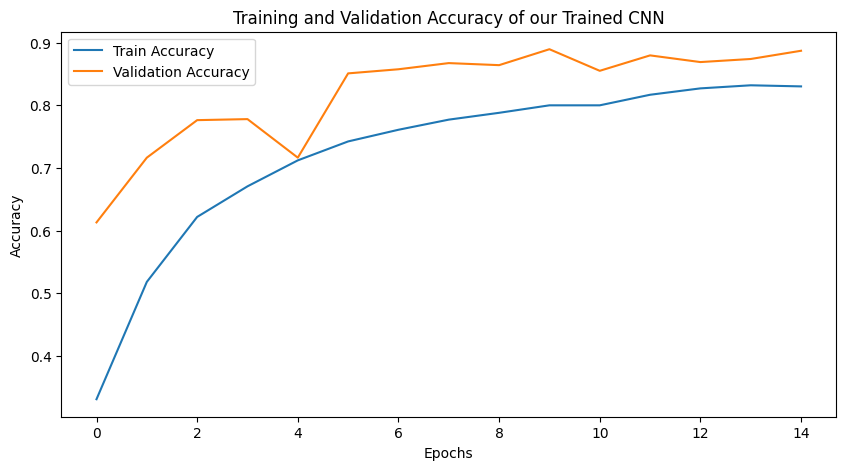

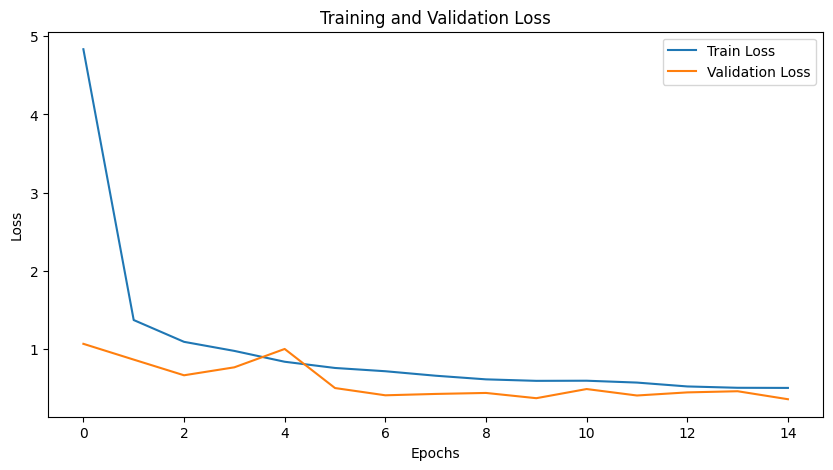

In [ ]:
results = model.evaluate(test_data)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy of our Trained CNN')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


CNN model without Data-Augmentation

In [ ]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=25,
    callbacks=[early_stopping]
)


Epoch 1/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 372s 4s/step - accuracy: 0.2497 - loss: 8.8482 - val_accuracy: 0.6213 - val_loss: 1.2157
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 141ms/step - accuracy: 0.5572 - loss: 1.2727 - val_accuracy: 0.7287 - val_loss: 0.7687
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.7010 - loss: 0.8760 - val_accuracy: 0.8115 - val_loss: 0.5843
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.7633 - loss: 0.7074 - val_accuracy: 0.8328 - val_loss: 0.5677
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.7984 - loss: 0.5948 - val_accuracy: 0.8393 - val_loss: 0.4965
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.8366 - loss: 0.5079 - val_accuracy: 0.8877 - val_loss: 0.3610
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.8611 - loss: 0.4003 - val_accuracy: 0.8975 - val_loss: 0.3254
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.8817 - loss: 0.3628 - val_accura

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9297 - loss: 0.3028
Test Loss: 0.2996188700199127, Test Accuracy: 0.9319671988487244


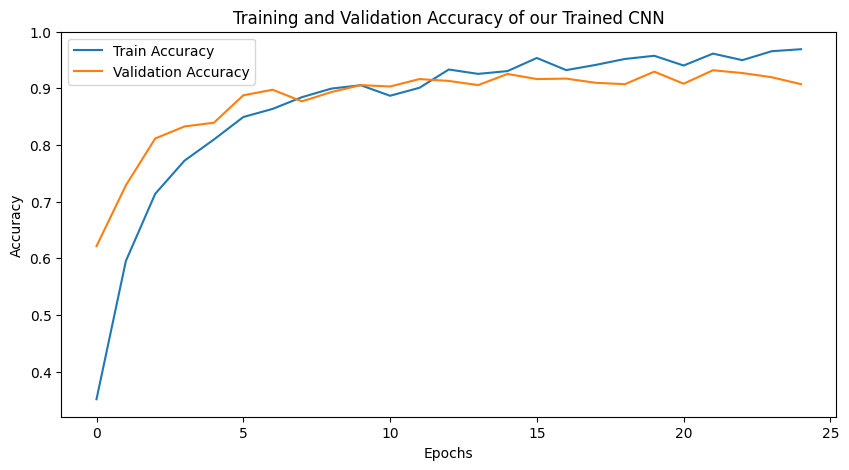

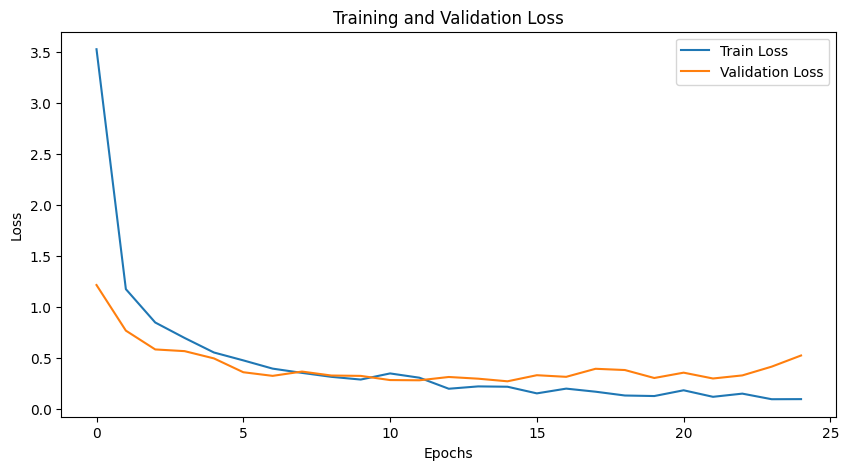

In [ ]:
results = model.evaluate(test_data)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy of our Trained CNN')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


#### CNN Model Findings

An accuracy of about 0.89 was found on our model with data augmentation, with no overfitting present, since the validation and train losses are both relatively close and low values, and the validation and test accuracy are both high and relatively close values. Due to data augmentation being used on the training dataset and not the validation dataset however, it resulted in a higher loss and lower accuracy with the training dataset compared to the vadliation dataset. This is becuase the data augmentation increases the difficulty of the training dataset by introducing transformations.
We then test the model again without data augmentation and acheive a slightly higher test accuracy (0.93) and we see the train accuracy higher than validation, and train loss lower than validation as expected.

This shows that while we had good reasons for trying data augmentation, it was not overall beneficial as the model was not able to improve from using a larger dataset with harder images. A possbility for why this is could be that the augmentations arent representative of our dataset. For instance, flipping, zooming, or rotating vehicle images might distort the object in ways that make it unrecognizable. Vehicles like airplanes, boats, or trains often have orientation-dependent features (e.g., wheels, wings). A rotated airplane might confuse the model.

#### Pretrained CNN Model
Since we want to leverage the power of transfer learning for vehicle image classification, we chose a pretrained CNN model, with VGG16 being chosen specifically. This model is known for its effectiveness in feature extraction and its abilily to generalize well across image classification tasks, making it a strong use for our project.

Pretrained CNN with data augmentation

In [ ]:
from tensorflow.keras.applications import VGG16

model = Sequential()
model.add(VGG16(include_top = False, pooling = "max"))
model.add(layers.Flatten())
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation("elu"))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='softmax'))

model.layers[0].trainable = False

model.compile(
    optimizer="nadam",
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    callbacks=[early_stopping]
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - accuracy: 0.5013 - loss: 1.5352 - val_accuracy: 0.8779 - val_loss: 0.3720
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.8436 - loss: 0.4700 - val_accuracy: 0.9254 - val_loss: 0.2402
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 0.8732 - loss: 0.3791 - val_accuracy: 0.9410 - val_loss: 0.2014
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 0.8899 - loss: 0.3430 - val_accuracy: 0.9434 - val_loss: 0.1894
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.8933 - loss: 0.2987 - val_accuracy: 0.9426 - val_loss: 0.1869
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step - accuracy: 0.8896 - loss: 0.2949 - val_accuracy: 0.9434 - val_loss: 0.1831
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - accuracy: 0.9158 - loss: 0.2505 - val_accuracy: 0.9418 - val_loss: 0.1800
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 17s 134m

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9541 - loss: 0.1561
Test Loss: 0.16169503331184387, Test Accuracy: 0.949999988079071


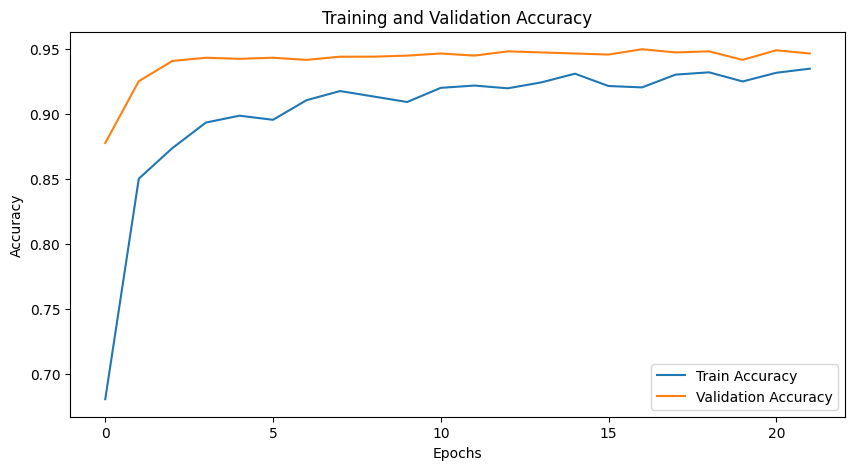

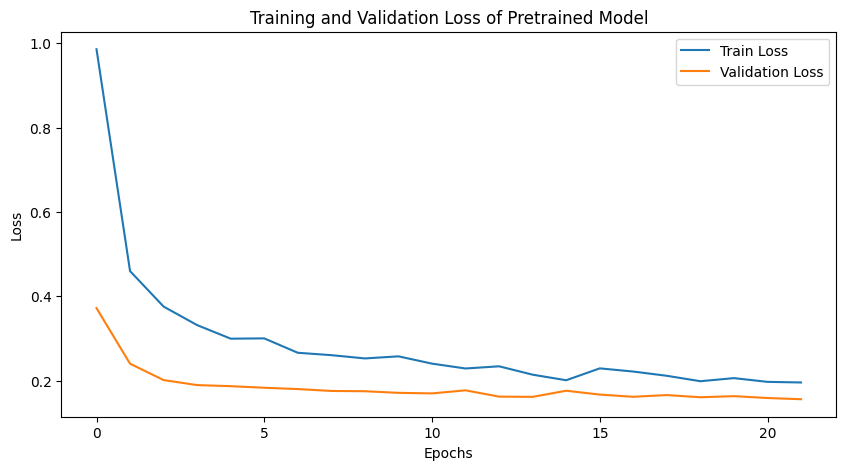

In [ ]:
results = model.evaluate(test_data)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss of Pretrained Model')
plt.show()

Pretrained CNN without data augmentation

In [ ]:
from tensorflow.keras.applications import VGG16

model = Sequential()
model.add(VGG16(include_top = False, pooling = "max"))
model.add(layers.Flatten())
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation("elu"))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='softmax'))

model.layers[0].trainable = False

model.compile(
    optimizer="nadam",
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.6021 - loss: 1.2430 - val_accuracy: 0.9205 - val_loss: 0.2396
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step - accuracy: 0.9115 - loss: 0.2993 - val_accuracy: 0.9426 - val_loss: 0.1768
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - accuracy: 0.9483 - loss: 0.1790 - val_accuracy: 0.9598 - val_loss: 0.1424
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.9556 - loss: 0.1481 - val_accuracy: 0.9557 - val_loss: 0.1402
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.9638 - loss: 0.1304 - val_accuracy: 0.9598 - val_loss: 0.1353
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9629 - loss: 0.1210 - val_accuracy: 0.9631 - val_loss: 0.1243
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.9713 - loss: 0.0952 - val_accuracy: 0.9648 - val_loss: 0.1269
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.9795 - loss: 0.0731 - val_accu

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9692 - loss: 0.1134
Test Loss: 0.12693578004837036, Test Accuracy: 0.9647541046142578


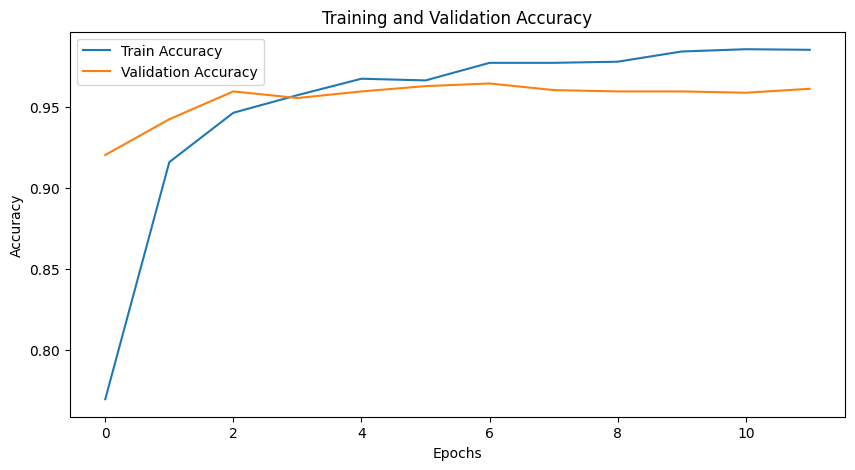

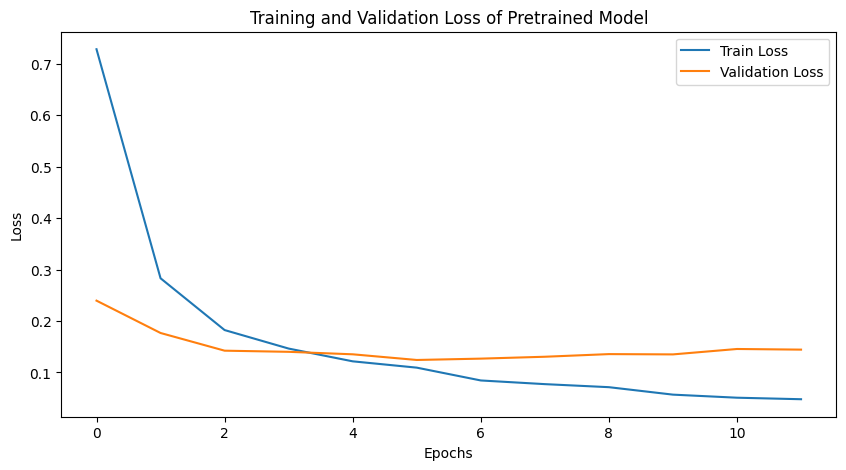

In [ ]:
results = model.evaluate(test_data)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss of Pretrained Model')
plt.show()

#### Pretrained model findings

An accuracy of 0.95 was achieved with the pretrained VGG16 model with data augmentation, significantly outperforming our custom CNN with data augmentation (0.89) and slightly outperforming the custom CNN without data augmentation (0.93).

When data augmentation was removed, the pretrained VGG16 model achieved a slightly higher test accuracy of 0.965. This result indicates that the model struggled with the harder augmented images and did not benefit from the additional variability. Similar to our custom CNN results, training accuracy and validation accuracy were both higher when data augmentation was not used.

This suggests that the pretrained VGG16 model, which already extracts robust and generalizable features from ImageNet, does not benefit from additional augmentation. In fact, augmentations like rotations or flips may have introduced unrealistic variations that confused the model and made the objects unrecognizable, like mentioned before.

By using clean, unaltered training data, the pretrained model was able to converge more effectively and achieve higher accuracy. However, slight overfitting was observed in the pretrained model without data augmentation. We suspect this overfitting is due to the relatively small training dataset, which caused the model to memorize the data more than we would like. Unfortunately, we were unable to enlarge the dataset with data augmentation without decreasing its accuracy.

#### Conclusions
In this project, we explored how deep learning models can classify vehicle images by implementing two main approaches:

1. Custom Trained Convolutional Neural Network (CNN):
Our custom CNN achieved a test accuracy of 0.93 without data augmentation.
When data augmentation was applied, test accuracy dropped slightly to 0.89. This shows a tradeoff: while data augmentation increases variability and helps prevent overfitting, it can sometimes degrade accuracy if the augmentations are not well-suited to the dataset.

2. Pretrained VGG16 Model (Transfer Learning):
The pretrained VGG16 model, leveraging transfer learning, achieved the highest performance with a test accuracy of 0.965.
Removing data augmentation allowed the model to achieve this result, as the pretrained VGG16 already extracts robust features from its pretraining on ImageNet. Augmentation did not improve performance and instead introduced unrealistic variations that confused the model which resulted in the lower accuracy of 0.95.

### Final Observations
Data Augmentation Tradeoffs: For the custom CNN, augmentation added variability but reduced accuracy slightly. For the pretrained model, augmentation harmed performance by introducing distortions that were not representative of the dataset.

Power of Transfer Learning: The pretrained VGG16 model demonstrated its ability to generalize well to a new task with minimal training. Its performance surpassed that of the custom CNN, highlighting the advantage of using pretrained models for smaller datasets.

Overfitting: Both models showed signs of slight overfitting, particularly the pretrained model when augmentation was removed. This was expected due to the small dataset size.